## Learning Gradient of a 2-D Nonconvex Function

In [9]:
## Learning gradient of a convex function

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt 
from jac_utils import check_jac_sym
from models import GradNet_M, GradNet_C
import numpy as np
import os 

seed = 42
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU available. Using : " + torch.cuda.get_device_name(0))
    torch.cuda.manual_seed(seed)
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

GPU available. Using : NVIDIA GeForce RTX 2080 Ti


In [10]:
# The nonconvex function
def nonconvex_function(x, y):
    return torch.sin(2*np.pi*x) * torch.cos(np.pi*y)/4 + x*y/2 - (y**2)/2

# The gradient of the nonconvex function
def field(z):
    x = z[:,0]
    y = z[:,1]

    grad_x = 0.5 * np.pi * torch.cos(2*np.pi*x)*torch.cos(np.pi*y) + y/2
    grad_y = -0.25*np.pi*torch.sin(2*np.pi*x)*torch.sin(np.pi*y) + x/2 - y
    return torch.stack([grad_x, grad_y]).T

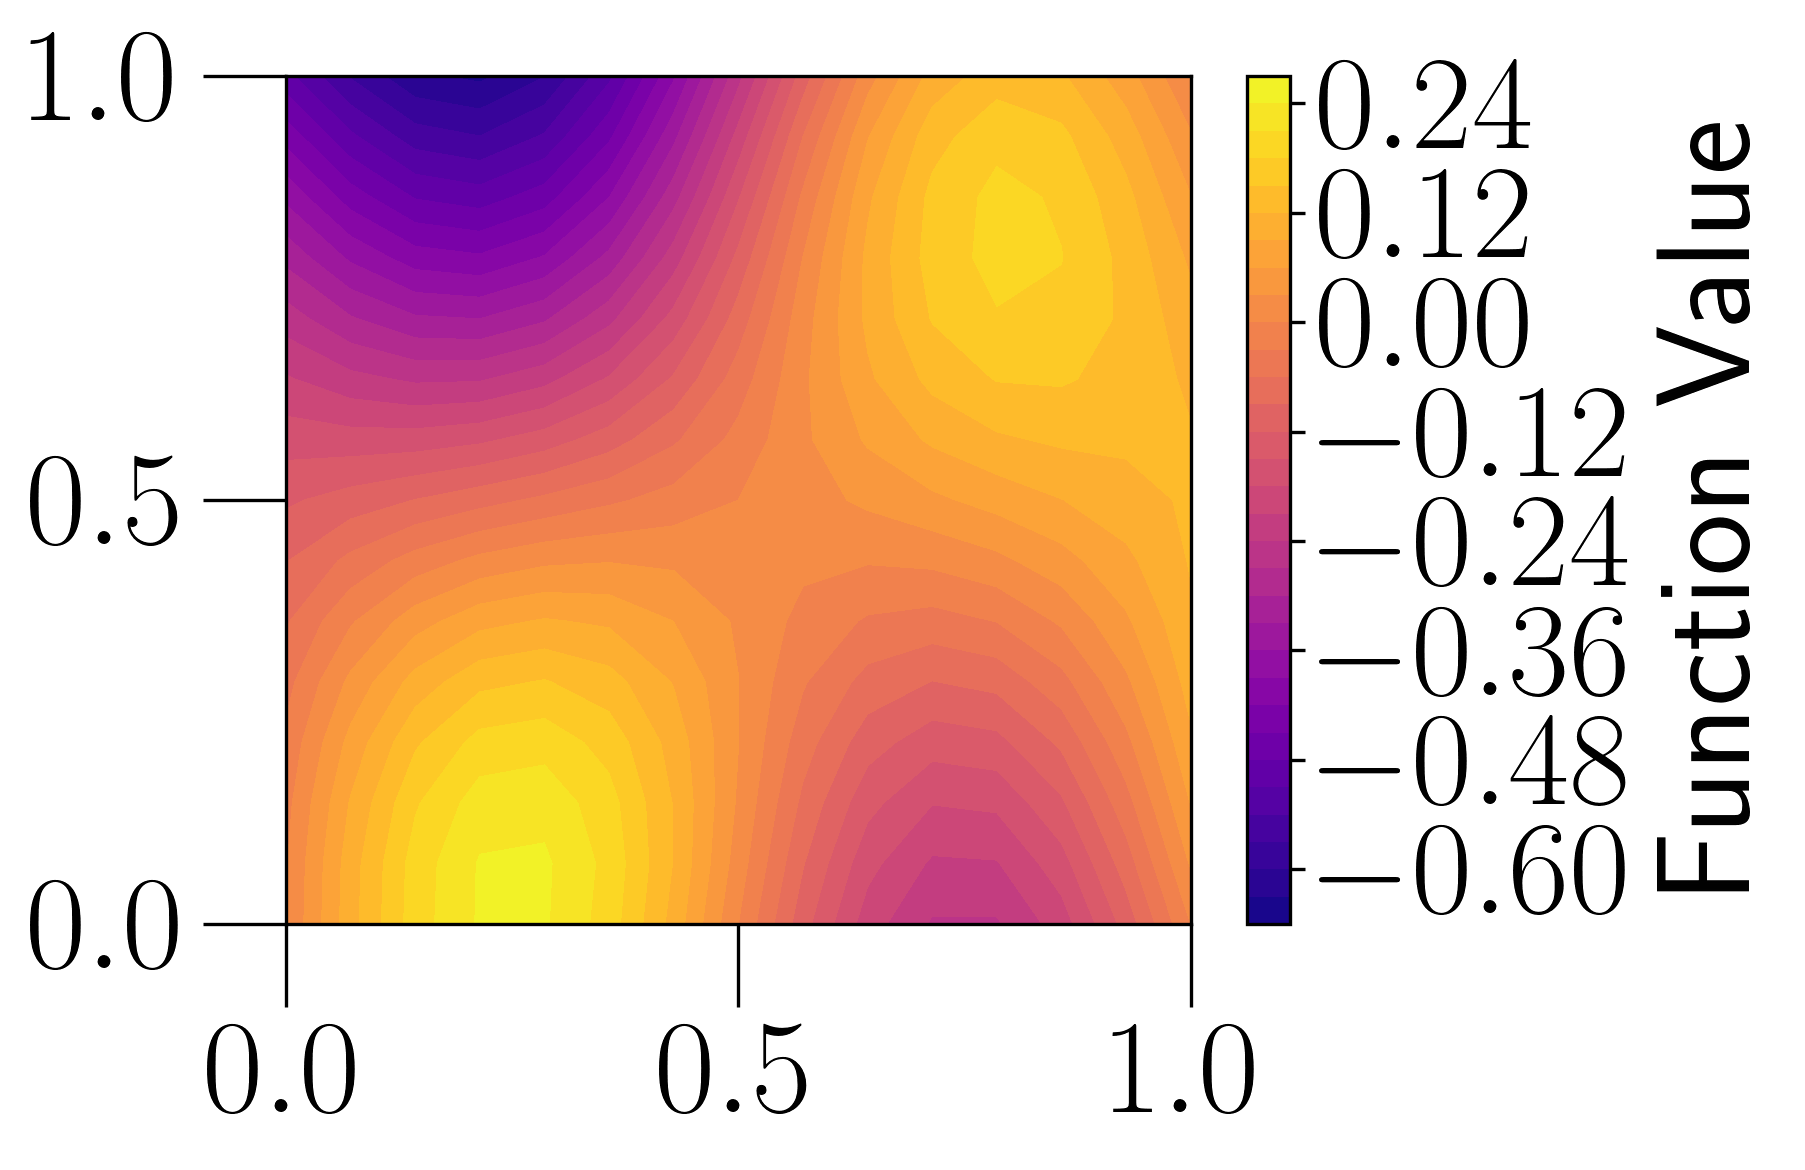

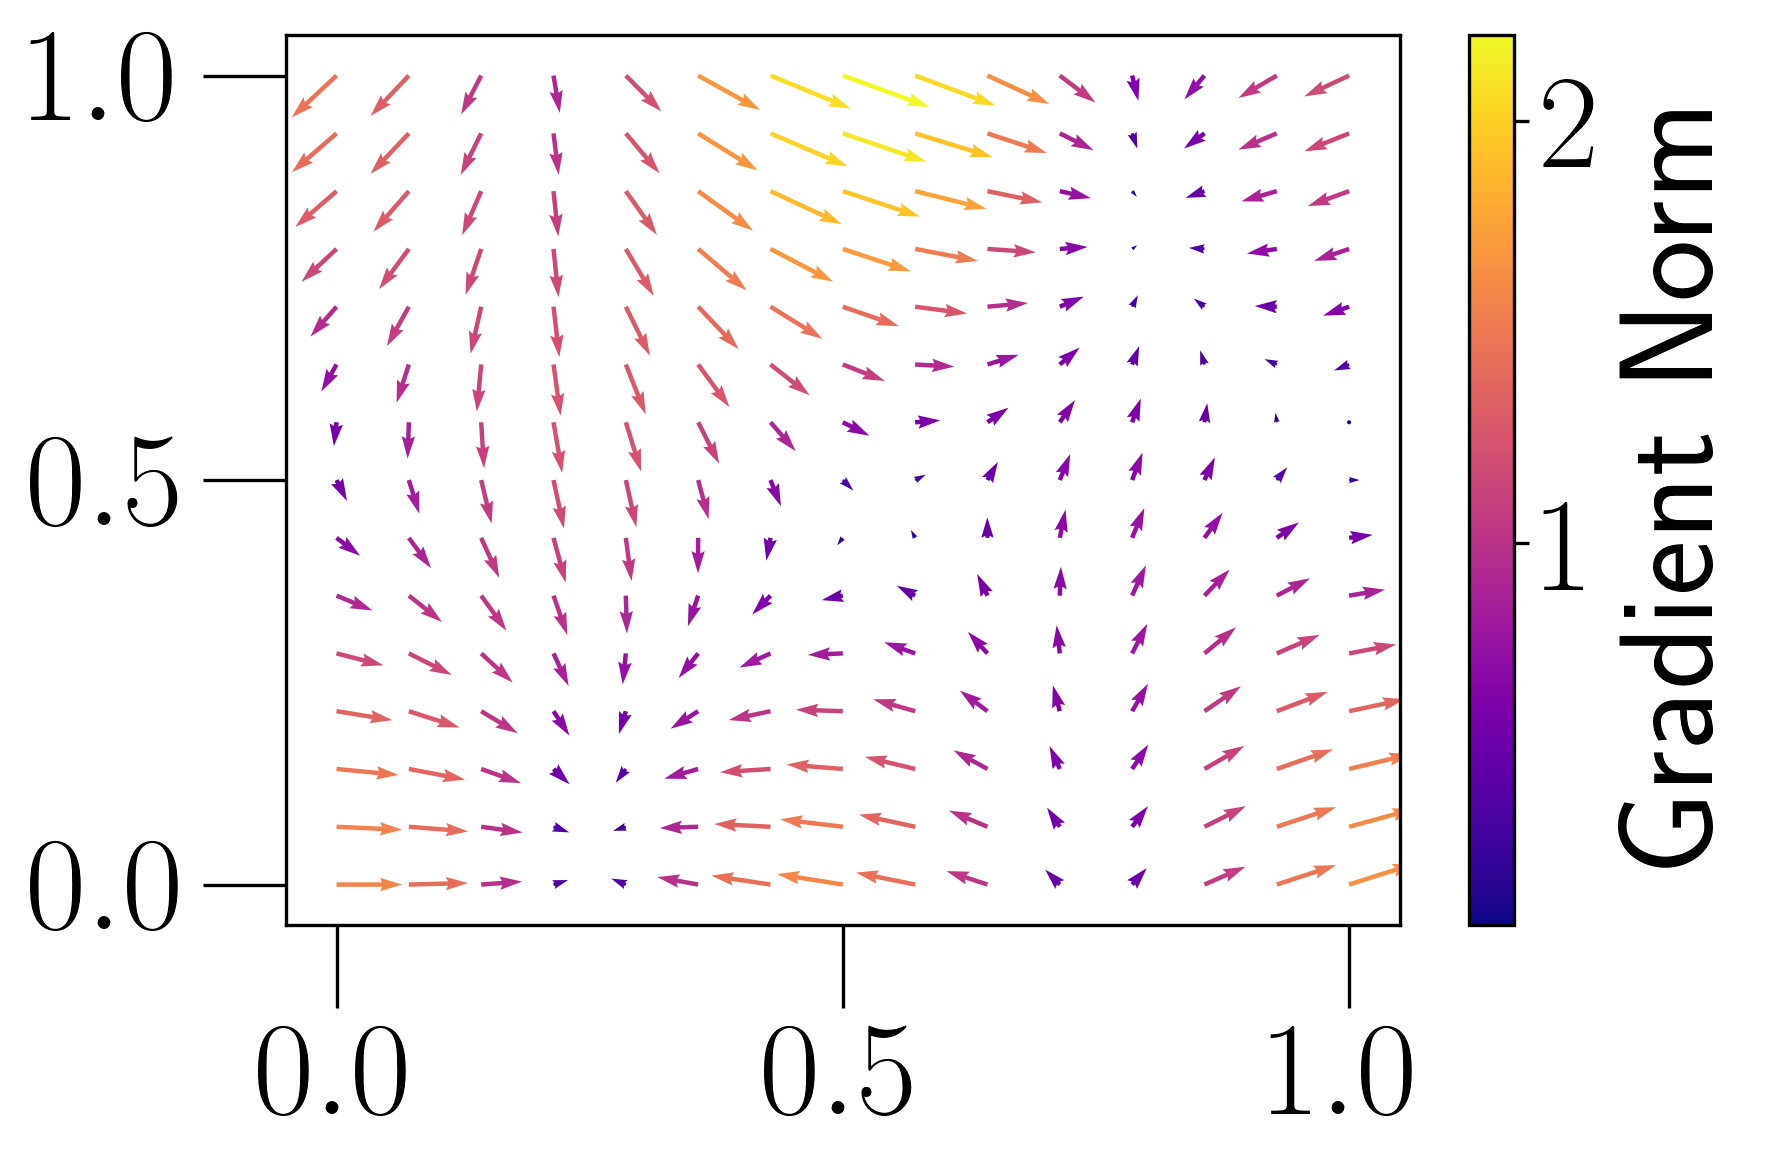

In [11]:
x = torch.linspace(0, 1, 15)
y = torch.linspace(0, 1, 15)

X, Y = torch.meshgrid(x, y)
space = torch.cat([torch.reshape(X,(-1,1)),torch.reshape(Y,(-1,1))],1)
grad = field(space)

plt.rcParams['text.usetex'] = True
label_size = 32
title_size= 48
cmap = 'plasma'
levels = 30

# Create contour plot
plt.figure(figsize=(6, 4), dpi=300)
plt.contourf(x, y, nonconvex_function(space[:,0], space[:,1]).view(x.numel(),x.numel()).T, levels=levels, cmap=cmap)
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.tick_params(axis='both', length=20, which='major', labelsize=label_size)
cbar = plt.colorbar()
cbar.set_label('Function Value', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 
plt.tight_layout()
plt.show()
plt.close()

# Create quiver plot
plt.figure(figsize=(6, 4), dpi=300)
p = plt.quiver(space[:,0], space[:,1], grad[:,0], grad[:,1], grad.norm(dim=-1), cmap=cmap)
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.tick_params(axis='both', length=20, which='major', labelsize=label_size)
cbar = plt.colorbar(p)
cbar.set_label('Gradient Norm', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 
plt.tight_layout()
plt.show()
plt.close()

In [12]:
def train_model(model, data_loader, val_pts, field, model_name):

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    best_val_loss = float('Inf')

    train_loss_hist = []
    val_loss_hist = []

    for epoch in range(1,201):
        avg_train_loss = 0
        for i, (x, y) in enumerate(data_loader):
            out = model(x.to(device))
            loss = F.mse_loss(out, y.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item()
        
        avg_train_loss = avg_train_loss / len(data_loader)
        
        with torch.no_grad():
            val_loss = F.mse_loss(model(val_pts.to(device)), field(val_pts).to(device)).item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_name+'.pt')
        
        train_loss_hist.append(avg_train_loss)
        val_loss_hist.append(val_loss)
        if epoch % 10 == 0:
            print("Epoch: ", epoch, "Train Loss: ", avg_train_loss, "Val Loss: ", val_loss)
    
    model.load_state_dict(torch.load(model_name+'.pt'))
    return model

## Train GradNets

In [13]:
train_pts = torch.rand(size=(100000, 2))
val_pts = torch.rand(size=(10000, 2))
data_loader = DataLoader(TensorDataset(train_pts, field(train_pts)), batch_size=1000, shuffle=True, num_workers=8)

gn_c = GradNet_C(num_layers=4, in_dim=2, embed_dim=7, activation=lambda : nn.Tanh()).to(device) # use learnable activation if desired
gn_m = GradNet_M(num_modules=4, in_dim=2, embed_dim=7, activation=lambda : nn.Softmax(dim=-1)).to(device) # use learnable activation if desired

print("GN-C parameters", sum(p.size().numel() for p in gn_c.parameters() if p.requires_grad))
print("GN-M parameters", sum(p.size().numel() for p in gn_m.parameters() if p.requires_grad))

gn_c = train_model(gn_c, data_loader=data_loader, val_pts=val_pts, field=field, model_name='gn_c')
gn_m = train_model(gn_m, data_loader=data_loader, val_pts=val_pts, field=field, model_name='gn_m')

GN-C parameters 100
GN-M parameters 94
Epoch:  10 Train Loss:  0.0016425013809930533 Val Loss:  0.0015104584163054824
Epoch:  20 Train Loss:  0.0007906141906278207 Val Loss:  0.0007708086050115526
Epoch:  30 Train Loss:  0.0006544009601930157 Val Loss:  0.0006108304369263351
Epoch:  40 Train Loss:  0.0005507276335265487 Val Loss:  0.0005060461116954684
Epoch:  50 Train Loss:  0.0004745161338360049 Val Loss:  0.00047736449050717056
Epoch:  60 Train Loss:  0.00041317307332064954 Val Loss:  0.00038303862675093114
Epoch:  70 Train Loss:  0.00036682654405012727 Val Loss:  0.00032791050034575164
Epoch:  80 Train Loss:  0.00032356155992602 Val Loss:  0.00028423662297427654
Epoch:  90 Train Loss:  0.000247935220686486 Val Loss:  0.0002146997576346621
Epoch:  100 Train Loss:  0.0002174907782318769 Val Loss:  0.00014169242058414966
Epoch:  110 Train Loss:  9.816377147217281e-05 Val Loss:  8.639660518383607e-05
Epoch:  120 Train Loss:  6.764796788047534e-05 Val Loss:  5.933232750976458e-05
Epoch:

## Plot Errors

In [14]:
xi = torch.linspace(0, 1, 100)
yi = torch.linspace(0, 1, 100)

Xi, Yi = torch.meshgrid(xi, yi)
space = torch.cat([torch.reshape(Xi,(-1,1)),torch.reshape(Yi,(-1,1))],1)
targ = field(space)


def get_norm_err(model):
    with torch.no_grad():
        model = model.cpu()
        out = model(space)
    return (targ - out).norm(dim=1).reshape(Xi.shape).T

check_jac_sym(gn_c.to(device), in_dim=2, device=device, domain=[0,1])
check_jac_sym(gn_m.to(device), in_dim=2, device=device, domain=[0,1])

jacobian symmetric test passed
jacobian symmetric test passed


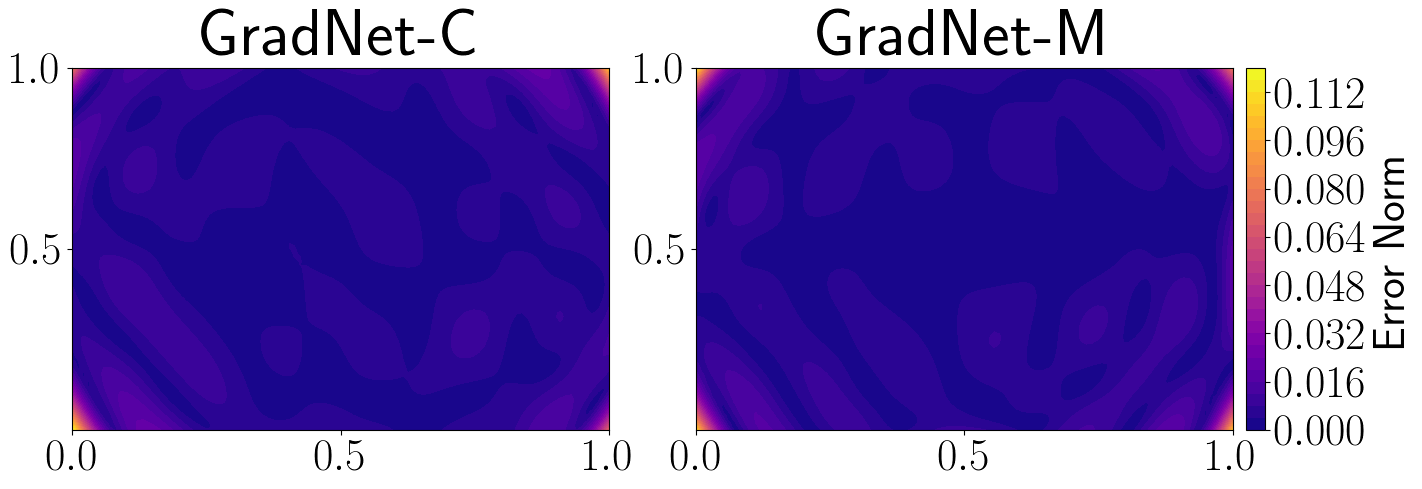

In [15]:
gnc_err = get_norm_err(gn_c)
gnm_err = get_norm_err(gn_m)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
cmax = max(gnc_err.amax(), gnm_err.amax())
plt1 = ax[0].contourf(xi, yi, gnc_err, levels=levels, cmap=cmap, vmin=0, vmax=cmax)
plt2 = ax[1].contourf(xi, yi, gnm_err, levels=levels, cmap=cmap, vmin=0, vmax=cmax)

ax[0].set_title('GradNet-C',fontsize=title_size)
ax[1].set_title('GradNet-M',fontsize=title_size)
ax[0].set_xticks([0, 0.5, 1.0])
ax[1].set_xticks([0, 0.5, 1.0])
ax[0].set_yticks([0.5, 1.0])
ax[1].set_yticks([0.5, 1.0])

ax[0].tick_params(axis='both', which='major', labelsize=label_size)
ax[1].tick_params(axis='both', which='major', labelsize=label_size)


plt.tight_layout()
if gnc_err.amax() > gnm_err.max():
    cbar = plt.colorbar(plt1, ax=ax, pad= 0.01)
else:
    cbar = plt.colorbar(plt2, ax=ax, pad= 0.01)
cbar.set_label('Error Norm', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 